## Python Data fitting with various functions - HW 12
Due Monday Dec 2, 2024



Dowload the data "miniDR17.fits" from the TCU Online Week 14:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


My example below will show how to remove Identified bad data, 
however data that are just bad in one quantity may remain

_Use masking to remove any remaining bad values (typically 9999 or -9999 in this file_ , <b>but check!!!! If you are not sure, ask!!!</b>). 

In [11]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [13]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

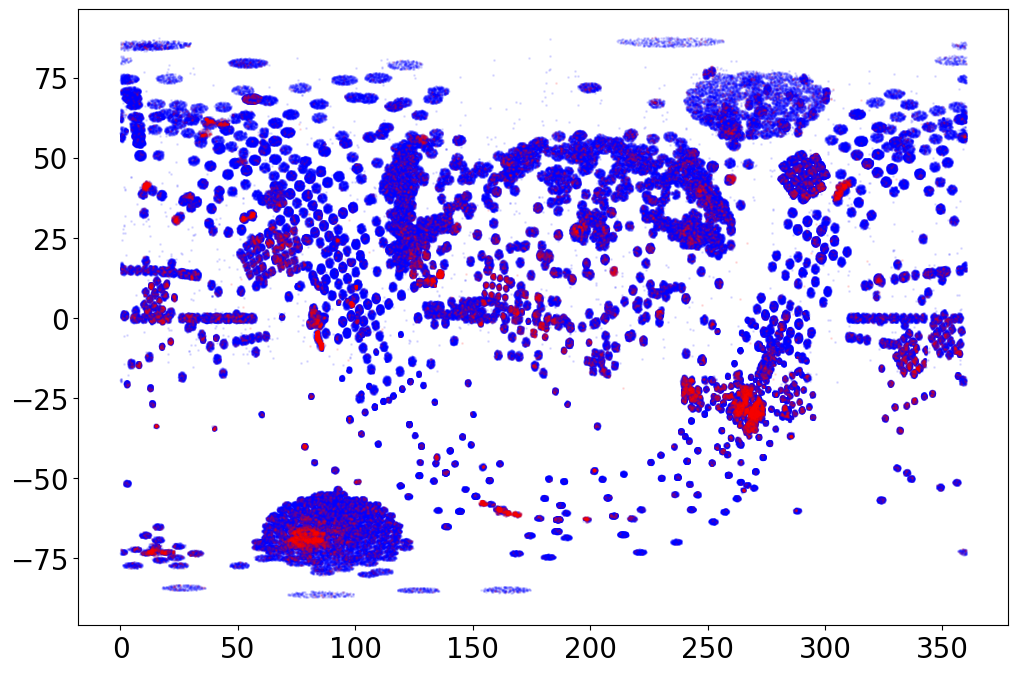

In [15]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)
ax.scatter(star['RA'][bad],star['DEC'][bad],s=1,c='r',alpha=0.1)


ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

LINEAR: -0.074, 16.223
POLY2: 0.005, -1.877, 130.634
COSFIT: 72.947, 0.018, -0.452, -5.700


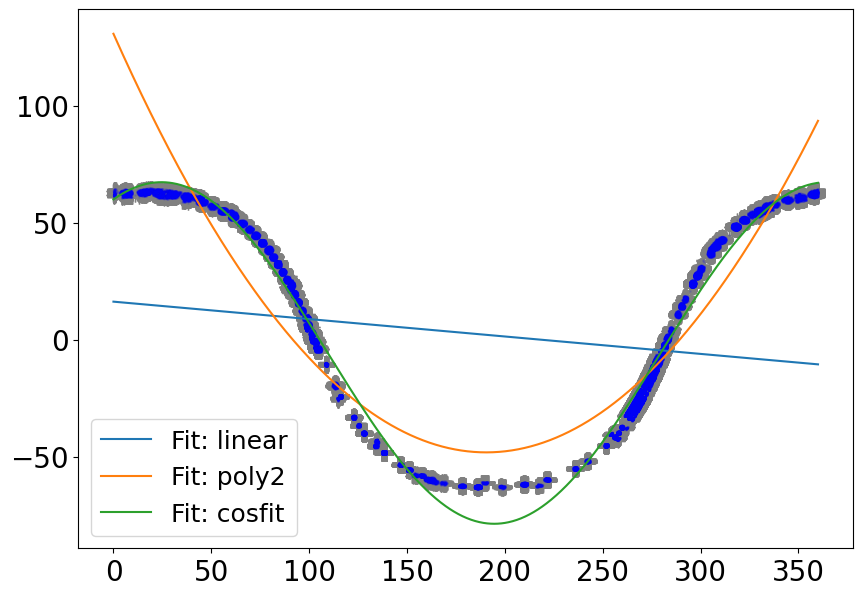

In [5]:
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 2) &\
     (star['GLAT'] > -2) 
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                          0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                         0.001,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                            0.001,p0=[60,0.02,0,0])
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['RA'][cut1],star['DEC'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['RA'][cut1]),star['DEC'][cut1], xerr=(0.001),
             yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,360,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.show()

# Homework #12

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_24_HW12a.ipynb

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.233, 0.054
POLY2: -0.074, -0.317, 0.048
POLY3: 0.077, 0.119, -0.220, 0.049


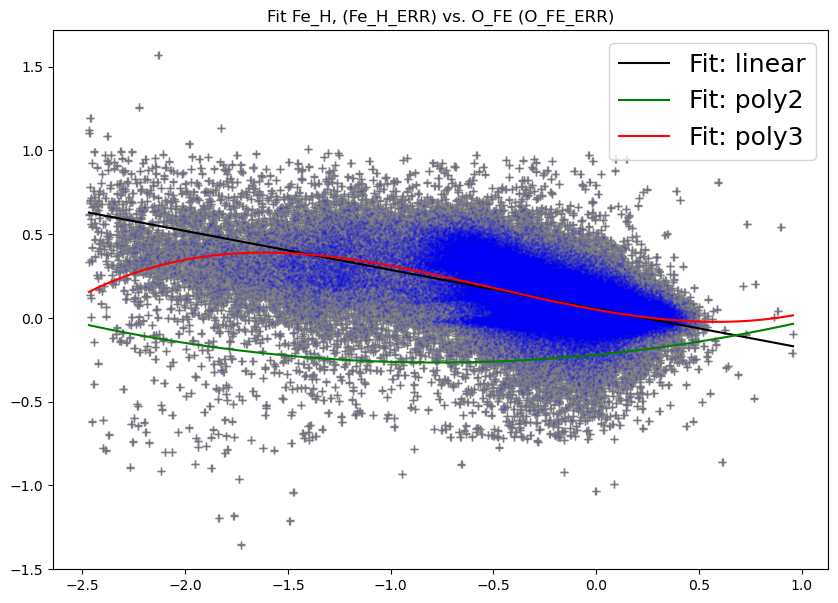

In [25]:
# write your fitting code, from part 1, and plot the results here
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

def linear(x, m, b):
    return m*x + b

def poly2(x, a, b, c):
    return a*(x**2) + (b*x) + c

def poly3(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + (c*x) + d

#=================================================================================
badbits = 2**23        # aspcapstar flag = Chemistry
suspectbits = 2**16    # star flag = Stellar parameters

ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      np.isfinite(star['aspcapflag']) & \
      np.isfinite(star['starflag']) & \
      np.isfinite(star['GLAT']) & \
      (star['GLAT'] > 20)

cut1 = np.where(ct1)[0]

#NO NANS OR INFS ><

clean_data = np.isfinite(star['Fe_H'][cut1]) & \
             np.isfinite(star['O_Fe'][cut1]) & \
             np.isfinite(star['Fe_H_ERR'][cut1]) & \
             np.isfinite(star['O_Fe_ERR'][cut1])

cit2 = cut1[clean_data]  

#=================================================================================
# Linear Fit 
def mcFit2(model, x, y, p0):
    popt, _ = opt.curve_fit(model, x, y, p0=p0)
    return popt
slope, intercept = mcFit2(linear, star['Fe_H'][cit2], star['O_Fe'][cit2], p0=[0, 0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
# Poly2 
def mcFit3(model, x, y, p0):
    popt, _ = opt.curve_fit(model, x, y, p0=p0)
    return popt

polyA, polyB, polyC = mcFit3(poly2, star['Fe_H'][cit2], star['O_Fe'][cit2], p0=[600, 1, 1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
# Poly3
polyA, polyB, polyC, polyD = mcFit4(poly3, star['Fe_H'][cit2], star['O_Fe'][cit2], p0=[600, 1, 1, 1])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD:.3f}')

#=================================================================================
# GRAPH PART 

fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)


ax1.scatter(star['Fe_H'][cit2], star['O_Fe'][cit2], s=1, c='b', alpha=0.1)

ax1.errorbar(star['Fe_H'][cit2], star['O_Fe'][cit2], xerr=0.001, yerr=0.001, ecolor='grey', fmt='none', capsize=3, zorder=0)

x_plot = np.linspace(min(star['Fe_H'][cit2]), max(star['Fe_H'][cit2]), 300)
ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Fit: linear', color='black')
#=================================================================================

# Plot poly2
ax1.plot(x_plot, poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2', color='green')

# Plot poly3
ax1.plot(x_plot, poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: poly3', color='red')

# Show legend
plt.legend(loc='best', fontsize=18)
plt.title("Fit Fe_H, (Fe_H_ERR) vs. O_FE (O_FE_ERR)")
plt.show()



## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.137, 0.040
POLY2: -0.020, -0.146, 0.041
POLY3: 0.076, 0.110, -0.120, 0.034


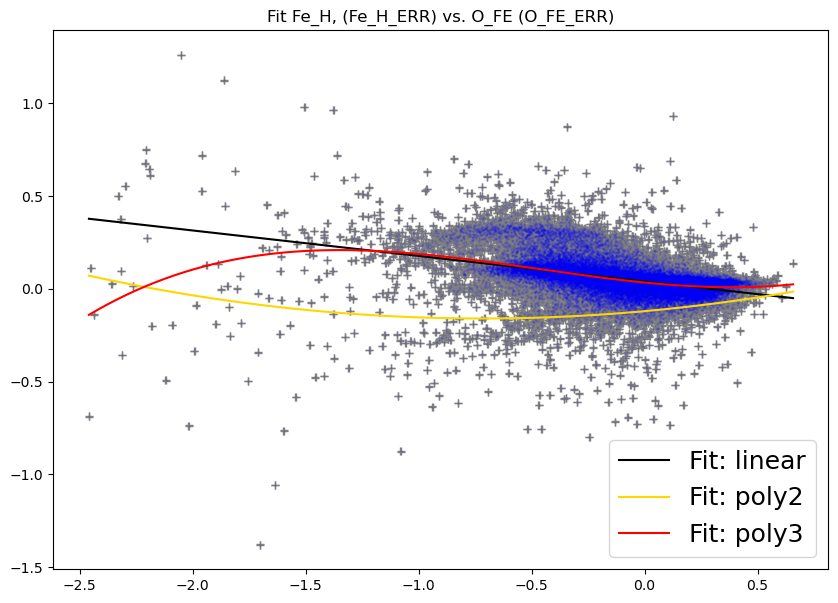

In [27]:
# write your fitting code, from part 1, and plot the results here
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

def linear(x, m, b):
    return m*x + b

def poly2(x, a, b, c):
    return a*(x**2) + (b*x) + c

def poly3(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + (c*x) + d

#=================================================================================
badbits = 2**23        # aspcapstar flag = Chemistry
suspectbits = 2**16    # star flag = Stellar parameters

ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      np.isfinite(star['aspcapflag']) & \
      np.isfinite(star['starflag']) & \
      np.isfinite(star['GLAT']) & \
     (star['GLAT'] < 1 ) &\
     (star['GLAT'] > -1)

cut1 = np.where(ct1)[0]

#NO NANS OR INFS ><

clean_data = np.isfinite(star['Fe_H'][cut1]) & \
             np.isfinite(star['O_Fe'][cut1]) & \
             np.isfinite(star['Fe_H_ERR'][cut1]) & \
             np.isfinite(star['O_Fe_ERR'][cut1])

cit2 = cut1[clean_data]  

#=================================================================================
# Linear Fit 
def mcFit2(model, x, y, p0):
    popt, _ = opt.curve_fit(model, x, y, p0=p0)
    return popt
slope, intercept = mcFit2(linear, star['Fe_H'][cit2], star['O_Fe'][cit2], p0=[0, 0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
# Poly2 
def mcFit3(model, x, y, p0):
    popt, _ = opt.curve_fit(model, x, y, p0=p0)
    return popt

polyA, polyB, polyC = mcFit3(poly2, star['Fe_H'][cit2], star['O_Fe'][cit2], p0=[600, 1, 1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
# Poly3
polyA, polyB, polyC, polyD = mcFit4(poly3, star['Fe_H'][cit2], star['O_Fe'][cit2], p0=[600, 1, 1, 1])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD:.3f}')

#=================================================================================
# GRAPH PART 

fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)


ax1.scatter(star['Fe_H'][cit2], star['O_Fe'][cit2], s=1, c='b', alpha=0.1)

ax1.errorbar(star['Fe_H'][cit2], star['O_Fe'][cit2], xerr=0.001, yerr=0.001, 
             ecolor='grey', fmt='none', capsize=3, zorder=0)

x_plot = np.linspace(min(star['Fe_H'][cit2]), max(star['Fe_H'][cit2]), 300)

ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Fit: linear', color='black')

# Plot poly2
ax1.plot(x_plot, poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2', color='gold')

# Plot poly3
ax1.plot(x_plot, poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: poly3', color='red')

# Show legend
plt.legend(loc='best', fontsize=18)
plt.title("Fit Fe_H, (Fe_H_ERR) vs. O_FE (O_FE_ERR)")
plt.show()

## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.000, 0.347
POLY3: A = 0.0, B = -0.0, C = 0.0, D = -4.1
EXPONENTIAL: A = 0.0, B = -19.0, C = 0.0, D = 0.3


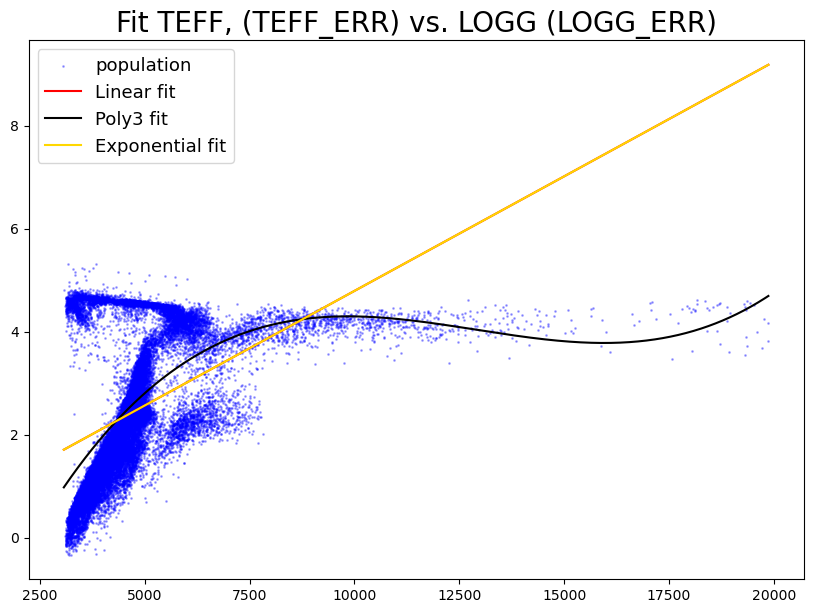

In [33]:
# write your fitting code and plot the results here
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt
from scipy.optimize import curve_fit
#=================================================================================
def linear(x, m, b):
    return m * x + b

def poly3(x, a, b, c, d):
    return a * (x**3) + b * (x**2) + c * x + d

def exponential_scaled(x, A, B, C, D):  #shoutout google for explaining that this is how it doesnt overflow 
    x_scaled = np.clip(x, 1e-10, None) 
    x_log = np.log(x_scaled) 
    return A * np.exp(B * x_log) + C * x + D

def exponential(x, A, B, C, D):
    return A * np.exp(B * x) + C * x + D

#=================================================================================
badbits = 2**23  # aspcapstar flag = Chemistry
suspectbits = 2**16  # star flag = Stellar parameters
#=================================================================================

ct3 = (
    (np.bitwise_and(star['aspcapflag'], badbits) == 0) &
    (np.bitwise_and(star['starflag'], suspectbits) == 0) &
    (star["GLON"] > 340) & (star["GLON"] < 360) &
    (np.isfinite(star["TEFF"])) & (np.isfinite(star["LOGG"])) &
    (np.isfinite(star["TEFF_ERR"])) & (np.isfinite(star["LOGG_ERR"]))
)

cit = np.where(ct3)[0]
x_data = star['TEFF'][cit]
y_data = star['LOGG'][cit]
#=================================================================================

# Linear Fit           #WAS GOING INSANE BC THIS WOULDNT SHOW UP
def mcFit3(model, x, y, p0):
    popt, _ = opt.curve_fit(model, x, y, p0=p0)
    return popt
slope, intercept = mcFit3(linear, x_data, y_data, p0=[0, 0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

# Poly333
polyA, polyB, polyC, polyD = mcFit4(poly3, x_data, y_data, p0=[0, 0, 0, 0])
print(f'POLY3: A = {polyA:.1f}, B = {polyB:.1f}, C = {polyC:.1f}, D = {polyD:.1f}')

#curve_fit
bounds = ([0, -20, -20, -20], [20, 20, 20, 20])

popt, pcov = curve_fit(exponential_scaled, x_data, y_data, p0=[1, 0.1, 1, 1], bounds=bounds, maxfev=10000)
expA, expB, expC, expD = popt
print(f'EXPONENTIAL: A = {expA:.1f}, B = {expB:.1f}, C = {expC:.1f}, D = {expD:.1f}')

#=================================================================================
fig3 = plt.figure(figsize=(10, 7))
ax3 = fig3.add_subplot(111)
ax3.xaxis.set_tick_params(labelsize=10)
ax3.yaxis.set_tick_params(labelsize=10)
ax3.scatter(x_data, y_data, s=1, c='blue', alpha=0.3, label='population')
x_plot = np.linspace(np.min(x_data), np.max(x_data), 1000) 

#=================================================================================
#plottin
ax3.plot(x_plot, linear(x_plot, slope, intercept), label='Linear fit', color='red')
ax3.plot(x_plot, poly3(x_plot, polyA, polyB, polyC, polyD), label='Poly3 fit', color='black')
ax3.plot(x_plot, exponential_scaled(x_plot, expA, expB, expC, expD), label='Exponential fit', color='gold')
#=================================================================================
#the ending 
plt.legend(loc='best', fontsize=13)
plt.title('Fit TEFF, (TEFF_ERR) vs. LOGG (LOGG_ERR)', fontsize=20)
plt.show()

## DATA FIT 4

Fit  a linear, a exponential, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (star['J'] - star['K']) (JK_ERR)__<br>
<br>
<b>NOTE: you will have to create a (J-K) error:</b>  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

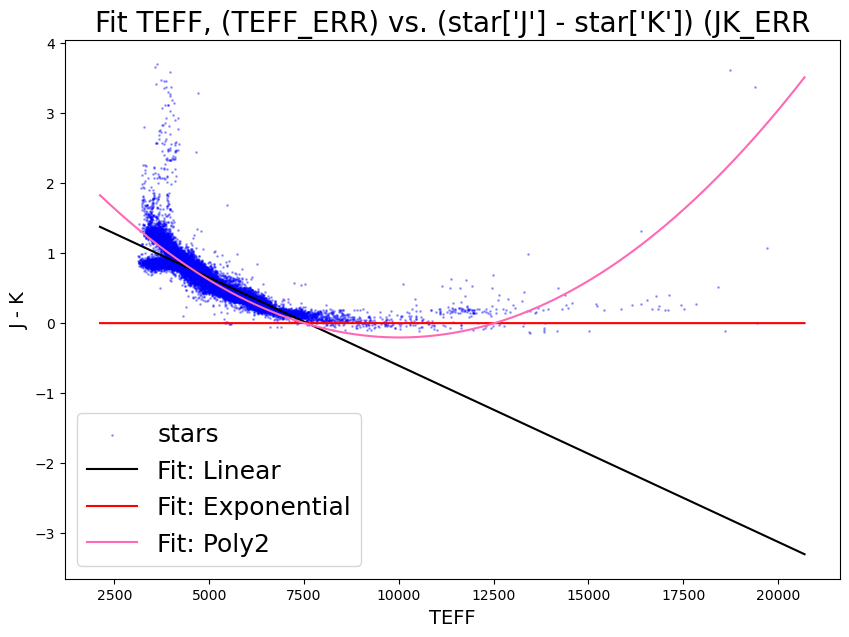

In [37]:
# write your fitting code and plot the results here
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt
from scipy.optimize import curve_fit


def linear(x, m, b):
    return m*x + b

def poly2(x, a, b, c):
    return a*(x**2) + (b*x) + c

def exponential(x, A, B, C, D):
    return A * np.exp(B * x) + C * x + D

#=================================================================================
badbits = 2**23  # aspcapstar flag = Chemistry
suspectbits = 2**16  # star flag = Stellar parameters
#=================================================================================

ct4 = (
    (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
    (np.bitwise_and(star['starflag'], suspectbits) == 0) &\
    (star["DEC"] < -50) &\
    (star["RA"] < 120) & (50 < star["RA"])& \
    (np.isfinite(star["TEFF"])) & (np.isfinite(star["J"]))& (np.isfinite(star["K"])) &\
    (np.isfinite(star["TEFF_ERR"])) & (np.isfinite(star['J_ERR'])) & (np.isfinite(star['K_ERR']))
)

cit = np.where(ct4)[0]
x_data = star["TEFF"][cit]
y_data = star['J'][cit] - star['K'][cit]
JK_ERR = np.sqrt( star['J_ERR'][cit] **2 + star['K_ERR'][cit]**2 )
#=================================================================================
if len(x_data) > 0:
    params, _ = curve_fit(linear, x_data, y_data, sigma=JK_ERR, p0=[0, 0])
    slope, intercept = params
    exp_guess_A = np.max(y_data) - np.min(y_data)
    exp_guess_B = -0.05
    exp_params, _ = curve_fit(exponential, x_data, y_data, sigma=JK_ERR, p0=[exp_guess_A, exp_guess_B, 0, 0])
    poly_params, _ = curve_fit(poly2, x_data, y_data, sigma=JK_ERR, p0=[0, 0, 0])
#=================================================================================
x_min, x_max = min(x_data), max(x_data)
x_plot = np.linspace(x_min - 1000, x_max + 1000, 20000)
#=================================================================================
plt.figure(figsize=(10, 7))
plt.scatter(x_data, y_data, s=1, c='b', alpha=0.3, label='stars')
plt.plot(x_plot, linear(x_plot, *params), label='Fit: Linear', color='black')
plt.plot(x_plot, exponential(x_plot, *exp_params), label='Fit: Exponential', color='red')
plt.plot(x_plot, poly2(x_plot, *poly_params), label='Fit: Poly2', color='hotpink')
#=================================================================================
plt.xlabel('TEFF', fontsize=14)
plt.ylabel('J - K', fontsize=14)
plt.title("Fit TEFF, (TEFF_ERR) vs. (star['J'] - star['K']) (JK_ERR", fontsize=20)
plt.legend(loc= 'best', fontsize=18)
plt.show()



## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON (0.0001) vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.001, -3.966
POLY3: -0.000, 0.014, -1.781, 27.971
COSFIT: 49.826, 0.023, 0.863, 0.585


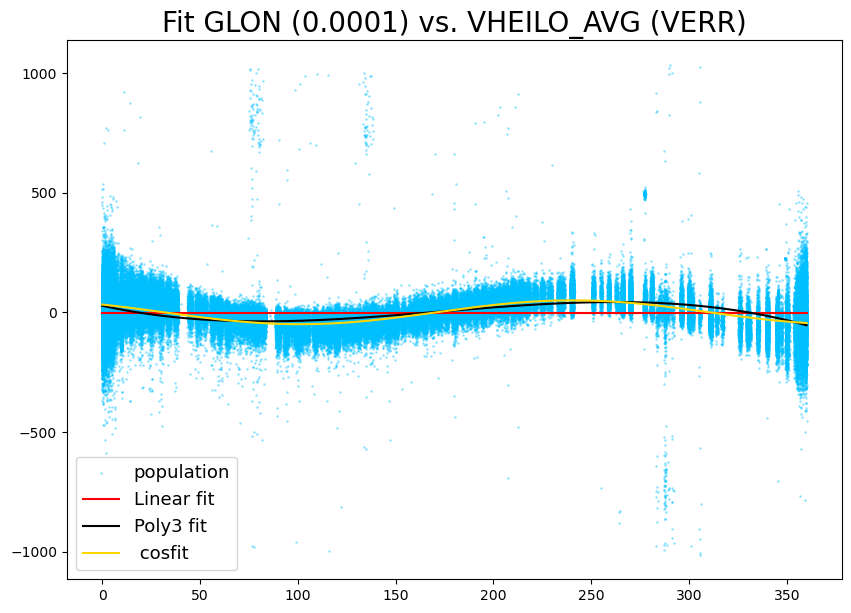

In [39]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b


def poly3(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + (c*x) + d

def cosfit(x, A, B, C, D):
    return A * np.cos(B * x + C) + D
#=================================================================================

badbits = 2**23  # aspcapstar flag = Chemistry
suspectbits = 2**16  # star flag = Stellar parameters
#=================================================================================
ct5 = (
    (np.bitwise_and(star['aspcapflag'], badbits) == 0) &
    (np.bitwise_and(star['starflag'], suspectbits) == 0) &
    (star["GLAT"] > -10) & (star["GLAT"] < 10) &
    (np.isfinite(star["GLON"])) & (np.isfinite(star['VHELIO_AVG']))
)

cit = np.where(ct5)[0]
x_data = star['GLON'][cit]
y_data = star['VHELIO_AVG'][cit]

#=================================================================================

# LINEAR FIT 
slope, intercept = mcFit2(linear, x_data, y_data, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY 3 FIT

polyA, polyB, polyC, polyD = mcFit3(poly3, x_data, y_data , p0=[500, 1, 1, 1])
print(f'POLY3: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD:.3f}')

#=================================================================================
## COS FIT 
cfA, cfB, cfC, cfD = mcFit4(cosfit, x_data,y_data,p0=[60,0.02,0,0])
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================
fig5 = plt.figure(figsize=(10, 7))
ax5 = fig5.add_subplot(111)
ax5.xaxis.set_tick_params(labelsize=10)
ax5.yaxis.set_tick_params(labelsize=10)
ax5.scatter(x_data, y_data, s=1, c='deepskyblue', alpha=0.3, label='population')
x_plot = np.linspace(np.min(x_data), np.max(x_data), 1000) 

#=================================================================================
#plottin
ax5.plot(x_plot, linear(x_plot, slope, intercept), label='Linear fit', color='red')
ax5.plot(x_plot, poly3(x_plot, polyA, polyB, polyC, polyD), label='Poly3 fit', color='black')
ax5.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label=' cosfit ', color='gold')
#=================================================================================
#the ending 
plt.legend(loc='best', fontsize=13)
plt.title('Fit GLON (0.0001) vs. VHEILO_AVG (VERR)', fontsize=20)
plt.show()



## DATA FIT 6

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

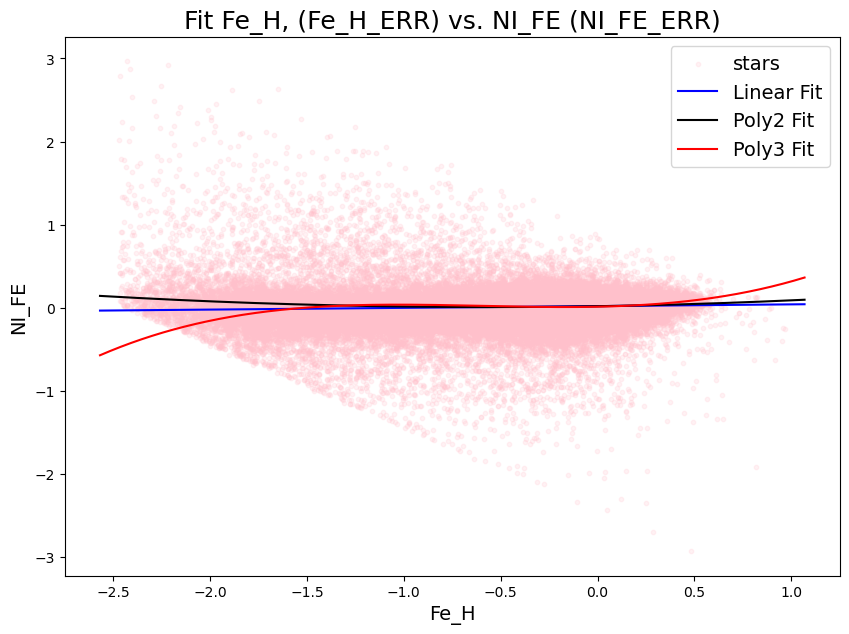

In [19]:
# write your fitting code and plot the results here
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits
import scipy.optimize as opt
from scipy.optimize import curve_fit


# Define fitting models
def linear(x, m, b):
    return m * x + b

def poly2(x, a, b, c):
    return a * (x**2) + b * x + c

def poly3(x, a, b, c, d):
    return a * (x**3) + b * (x**2) + c * x + d

#=================================================================================
badbits = 2**23        # aspcapstar flag = Chemistry
suspectbits = 2**16    # star flag = Stellar parameters

#=================================================================================
# Apply selection criteria
ct7 = (
    (np.bitwise_and(star['aspcapflag'], badbits) == 0) & 
    (np.bitwise_and(star['starflag'], suspectbits) == 0) & 
    np.isfinite(star["Fe_H"]) & np.isfinite(star["NI_FE"]) &
    np.isfinite(star["Fe_H_ERR"]) & np.isfinite(star["NI_FE_ERR"])
)

cit = np.where(ct7)[0]
x_data = star['Fe_H'][cit]
y_data = star['NI_FE'][cit]
err = np.sqrt(star['Fe_H_ERR'][cit]**2 + star['NI_FE_ERR'][cit]**2)

#=================================================================================
# must use if statment

if len(x_data) > 0:
    params_linear, _ = curve_fit(linear, x_data, y_data, sigma=err, absolute_sigma=True)
    params_poly2, _ = curve_fit(poly2, x_data, y_data, sigma=err, absolute_sigma=True)
    params_poly3, _ = curve_fit(poly3, x_data, y_data, sigma=err, absolute_sigma=True)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(x_data, y_data, s=10, c='pink', alpha=0.2, label='stars')
    
    x_plot = np.linspace(min(x_data) - 0.1, max(x_data) + 0.1, 1000)
    
    ax.plot(x_plot, linear(x_plot, *params_linear), label='Linear Fit', color='blue')
    ax.plot(x_plot, poly2(x_plot, *params_poly2), label='Poly2 Fit', color='black')
    ax.plot(x_plot, poly3(x_plot, *params_poly3), label='Poly3 Fit', color='red')
#=================================================================================
    ax.set_xlabel('Fe_H', fontsize=14)
    ax.set_ylabel('NI_FE', fontsize=14)
    ax.set_title('Fit Fe_H, (Fe_H_ERR) vs. NI_FE (NI_FE_ERR)', fontsize=18)
    plt.legend(loc='best', fontsize=14)
    plt.show()

else:
    print("No data available")